In [1]:
!pip install featuretools

In [2]:
import pandas as pd
import numpy as np
import featuretools as ft

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
prefix = "drive/My Drive/automl/data/"

# **Диаграмма организации БД:**

![data organization](https://i.imgur.com/HRhd2Y0.png)

# **Посмотрим на наши сущности:**

### product-category-name-translation:

In [4]:
product_category = pd.read_csv(prefix + "product_category_name_translation.csv")
product_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Здесь описываются переводы названий категорий с португальского на английский.

### olist-sellers-dataset:

In [5]:
olist_sellers = pd.read_csv(prefix + "olist_sellers_dataset.csv")
olist_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [0]:
# Сохраним категориальные признаки для последующего использования one-hot-encoding
categorical = ['seller_city', 'seller_state']

Датасет описывает местоположение продавцов.

### olist-products-dataset:

In [7]:
olist_products = pd.read_csv(prefix + "olist_products_dataset.csv")
olist_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [0]:
categorical.append('product_category_name')

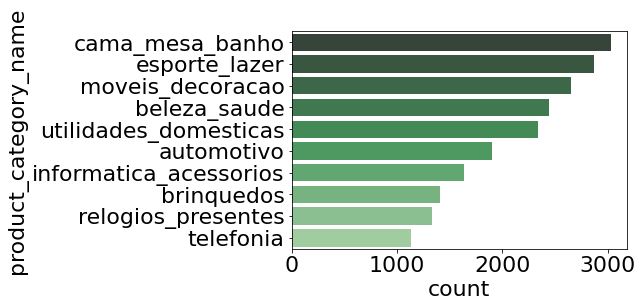

In [9]:
# Посмотрим на категории товаров и на их распределения
TOP = 10

ax = sns.countplot(y='product_category_name', data=olist_products, palette="Greens_d",
              order=olist_products['product_category_name'].value_counts().iloc[:TOP].index, orient='h')

В датасете содержатся характеристики товаров: вес, высота и т.д.

### olist-orders-dataset:

In [10]:
olist_orders = pd.read_csv(prefix + "olist_orders_dataset.csv")
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [0]:
categorical.append('order_status')

In [0]:
# Сконвертируем колонки с данными в число секунд от 01.01.1970	
data_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

In [13]:
import datetime as dt
from datetime import datetime
from datetime import date

fmt = "%Y-%m-%d %H:%M:%S"
date = datetime.strptime(olist_orders.iloc[0, 3], fmt)
print(date.day)
print(date.month)
print(date.year)
print("~~~~~~~~")
print(date.hour)
print(date.minute)
print(date.second)

2
10
2017
~~~~~~~~
10
56
33


In [0]:
start_date = dt.datetime(1970, 1, 1)

def convert_to_seconds(str_date):
    if str_date is None or type(str_date) != str:
        return 0
    global start_date, fmt
    date = datetime.strptime(str_date, fmt)
    return (date - start_date).total_seconds()

In [15]:
print(olist_orders.shape)
for data_column in data_columns:
    olist_orders[data_column + '_seconds'] = olist_orders[data_column].apply(convert_to_seconds)
print(olist_orders.shape)

(99441, 8)
(99441, 13)


In [0]:
olist_orders.drop(data_columns, axis=1, inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler

# Отнормируем их
for data_column in data_columns:
    olist_orders[data_column + '_seconds'] = StandardScaler().fit_transform(olist_orders[data_column + '_seconds'].values.reshape((-1, 1)))

olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp_seconds,order_approved_at_seconds,order_delivered_carrier_date_seconds,order_delivered_customer_date_seconds,order_estimated_delivery_date_seconds
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,-0.585074,-0.086347,0.095349,0.143087,-0.646198
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,1.337288,0.326153,0.221759,0.243743,1.322733
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,1.431634,0.344548,0.227322,0.247127,1.467604
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,-0.276909,-0.020498,0.116250,0.160533,-0.264265
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,0.289745,0.100616,0.152382,0.186217,0.216444


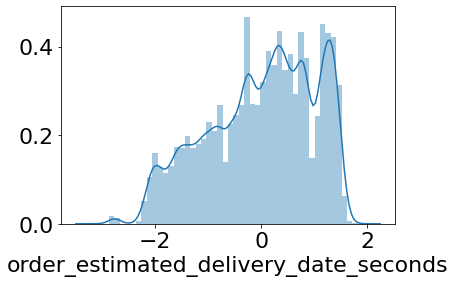

In [18]:
ax = sns.distplot(olist_orders['order_estimated_delivery_date_seconds'])

Хранит временные точки совершения заказов и текущее состояние.

### olist-order-reviews-dataset

In [19]:
olist_order_reviews = pd.read_csv(prefix + 'olist_order_reviews_dataset.csv')
olist_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [20]:
nan_num = olist_order_reviews['review_comment_title'].isna().sum()
rate = 100 * (olist_order_reviews.shape[0] - nan_num) / olist_order_reviews.shape[0]
print("Доля ненулевых заголовков комментариев:", rate, "%")
print("Число заголовков комментариев:", olist_order_reviews.shape[0])
print("Число ненулевых заголовков комментариев:", olist_order_reviews.shape[0] - nan_num)

Доля ненулевых заголовков комментариев: 11.715 %
Число заголовков комментариев: 100000
Число ненулевых заголовков комментариев: 11715


In [21]:
nan_num = olist_order_reviews['review_comment_message'].isna().sum()
rate = 100 * (olist_order_reviews.shape[0] - nan_num) / olist_order_reviews.shape[0]
print("Доля ненулевых комментариев:", rate, "%")
print("Число комментариев:", olist_order_reviews.shape[0])
print("Число ненулевых комментариев:", olist_order_reviews.shape[0] - nan_num)

Доля ненулевых комментариев: 41.753 %
Число комментариев: 100000
Число ненулевых комментариев: 41753


In [22]:
# Найдем процент ненулевых заголовков и описаний вместе
nan_num = (olist_order_reviews['review_comment_message'].isna() | olist_order_reviews['review_comment_title'].isna()).sum()
rate = 100 * (olist_order_reviews.shape[0] - nan_num) / olist_order_reviews.shape[0]
print("Доля полноценных комментариев:", rate, "%")
print("Число комментариев:", olist_order_reviews.shape[0])
print("Число полноценных комментариев:", olist_order_reviews.shape[0] - nan_num)

Доля полноценных комментариев: 9.986 %
Число комментариев: 100000
Число полноценных комментариев: 9986


In [23]:
# Вывод: избавимся от заголовков, будем использовать только описания. Сократим выборку до 41.732%
new_olist_order_reviews = olist_order_reviews.loc[~(olist_order_reviews['review_comment_message'].isna()), :]
print("Размер подвыборки:", new_olist_order_reviews.shape)

Размер подвыборки: (41753, 7)


In [0]:
# Дропнем почти нулевой столбец заголовков
olist_order_reviews.drop(['review_comment_title'], axis=1, inplace=True)

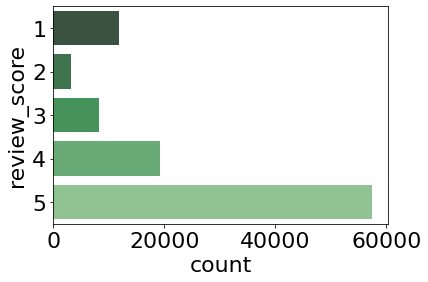

In [25]:
# Посмотрим на распределение поставленных пользователями оценок

ax = sns.countplot(y='review_score', data=olist_order_reviews, palette="Greens_d")

### olist-order-payments-dataset

In [26]:
olist_order_payments = pd.read_csv(prefix + 'olist_order_payments_dataset.csv')
olist_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [0]:
categorical.append('payment_type')

(0.0, 0.001)

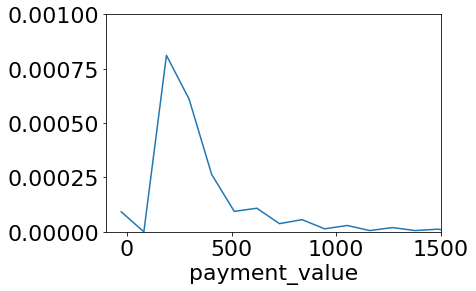

In [28]:
ax = sns.distplot(olist_order_payments['payment_value'], hist=False)
ax.set_xlim([-100, 1500])
ax.set_ylim([0, 0.001])

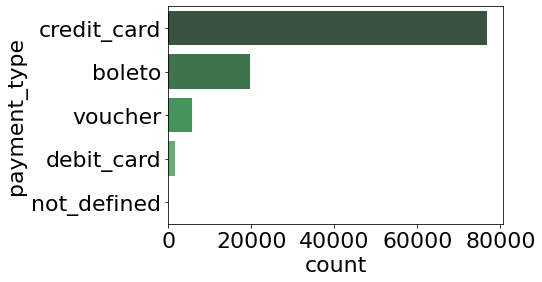

In [29]:
ax = sns.countplot(y='payment_type', data=olist_order_payments, palette="Greens_d")

### olist-order-items-dataset

In [30]:
olist_order_items = pd.read_csv(prefix + 'olist_order_items_dataset.csv')
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [0]:
olist_order_items['shipping_limit_date_seconds'] = olist_order_items['shipping_limit_date'].apply(convert_to_seconds)
olist_order_items.drop(['shipping_limit_date'], axis=1, inplace=True)

(0.0, 0.004)

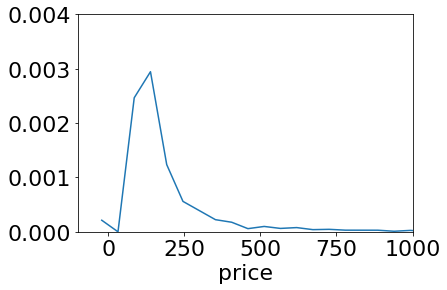

In [32]:
ax = sns.distplot(olist_order_items['price'], hist=False)
ax.set_xlim([-100, 1000])
ax.set_ylim([0, 0.004])

### olist-geolocation-dataset

In [33]:
olist_geolocation = pd.read_csv(prefix + 'olist_geolocation_dataset.csv')
olist_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [0]:
# TEMP: пока геолокация не учитывается 
# categorical.extend(['geolocation_city', 'geolocation_state'])

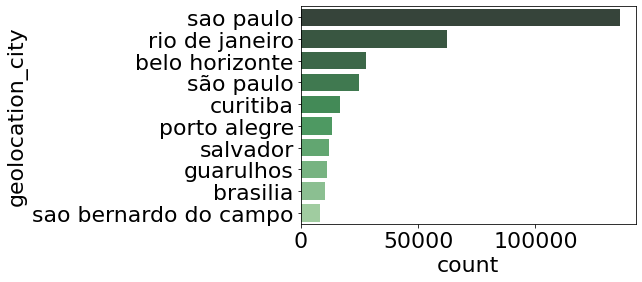

In [35]:
# Посмотрим на распределение товаров по городам

ax = sns.countplot(y='geolocation_city', data=olist_geolocation, palette="Greens_d",
              order=olist_geolocation['geolocation_city'].value_counts().iloc[:TOP].index, orient='h')

### olist-customers-dataset

In [36]:
olist_customers = pd.read_csv(prefix + 'olist_customers_dataset.csv')
olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [0]:
categorical.extend(['customer_city', 'customer_state'])

In [0]:
# TEMP: drop zip code
olist_customers.drop(['customer_zip_code_prefix'], axis=1, inplace=True)

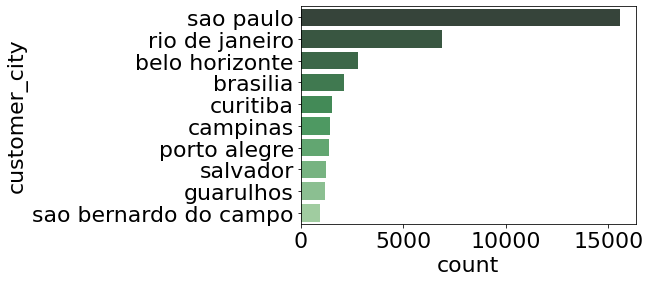

In [39]:
# Посмотрим на распределение городов покупателей

ax = sns.countplot(y='customer_city', data=olist_customers, palette="Greens_d",
              order=olist_customers['customer_city'].value_counts().iloc[:TOP].index, orient='h')

# **Объединим предобработанные сущности:**

In [40]:
train = olist_orders.merge(olist_order_items, on='order_id', how='left')
train = train.merge(olist_order_payments, on='order_id', how='left', validate='m:m')
train = train.merge(new_olist_order_reviews, on='order_id', how='inner')
train = train.merge(olist_products, on='product_id', how='left')
train = train.merge(olist_customers, on='customer_id', how='left')
train = train.merge(olist_sellers, on='seller_id', how='left')


print("Размер выборки до OHE:", train.shape)

Размер выборки до OHE: (51250, 38)


In [0]:
# Не забудем удалить заголовки
train.drop(['review_comment_title'], axis=1, inplace=True)

In [42]:
sm = 0
for col in train.columns:
    sm += train[col].isna().sum()
    print(col, ":", train[col].isna().sum())
print(sm)

order_id : 0
customer_id : 0
order_status : 0
order_purchase_timestamp_seconds : 0
order_approved_at_seconds : 0
order_delivered_carrier_date_seconds : 0
order_delivered_customer_date_seconds : 0
order_estimated_delivery_date_seconds : 0
order_item_id : 582
product_id : 582
seller_id : 582
price : 582
freight_value : 582
shipping_limit_date_seconds : 582
payment_sequential : 3
payment_type : 3
payment_installments : 3
payment_value : 3
review_id : 0
review_score : 0
review_comment_message : 0
review_creation_date : 0
review_answer_timestamp : 0
product_category_name : 1357
product_name_lenght : 1357
product_description_lenght : 1357
product_photos_qty : 1357
product_weight_g : 596
product_length_cm : 596
product_height_cm : 596
product_width_cm : 596
customer_unique_id : 0
customer_city : 0
customer_state : 0
seller_zip_code_prefix : 582
seller_city : 582
seller_state : 582
13062


In [0]:
train.drop(['seller_zip_code_prefix'], axis=1, inplace=True)

In [0]:
# Заполним оставшиеся NaN-значения средними для числовых признаков
for col in train.columns:
    # удалим id's
    if col[-2:] == 'id':
        train.drop([col], axis=1, inplace=True)
    if col not in categorical and col[-2:] != 'id' and type(train.loc[0, col]) != str:
        train[col].fillna(train[col].mean(), inplace=True)

Целевой переменной положим **price** в таблице **items**.


In [0]:
# Применим OHE ко всем категориальным признакам

# Для уменьшения датасета из кат признаков оставим только тип товара
small_categorical = ['product_category_name']

for feature in small_categorical:
    feature_dummies = pd.get_dummies(train[feature], prefix=feature + '_', dtype=float)
    train = pd.concat([train, feature_dummies], axis=1)

In [0]:
train.drop(categorical, axis=1, inplace=True)

In [47]:
sm = 0
for col in train.columns:
    sm += train[col].isna().sum()
print(sm)

0


In [48]:
print(train.shape)

(51250, 95)


In [0]:
train.to_csv("drive/My Drive/automl/data/categorical_less_train.csv", index=False)